In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa  # for audio processing

In [85]:
import os

audio_dir = '/kaggle/input/rain-data-master-8k/rainfall_sound_8k'
files = os.listdir(audio_dir)

# Print the first 5 audio file names
print(files[:5])


['2023_12_17_03_11_57_571853.wav', '2023_12_17_16_16_12_940548.wav', '2024_05_21_22_30_34_452070.wav', '2023_12_17_05_02_34_604655.wav', '2023_12_17_04_56_56_315311.wav']


In [86]:
import librosa

signal, sr = librosa.load(sample_file, sr=None)  # Load original sampling rate
print("Sampling rate:", sr)

Sampling rate: 8000


In [87]:
print("Length in samples:", len(signal))

Length in samples: 24000


In [88]:
import pandas as pd

df = pd.read_csv('/kaggle/input/rain-data-master-8k/rain_data_mechanical_master.csv')
print(df.columns)

Index(['Time', 'device_frmpayload_data_rainfall'], dtype='object')


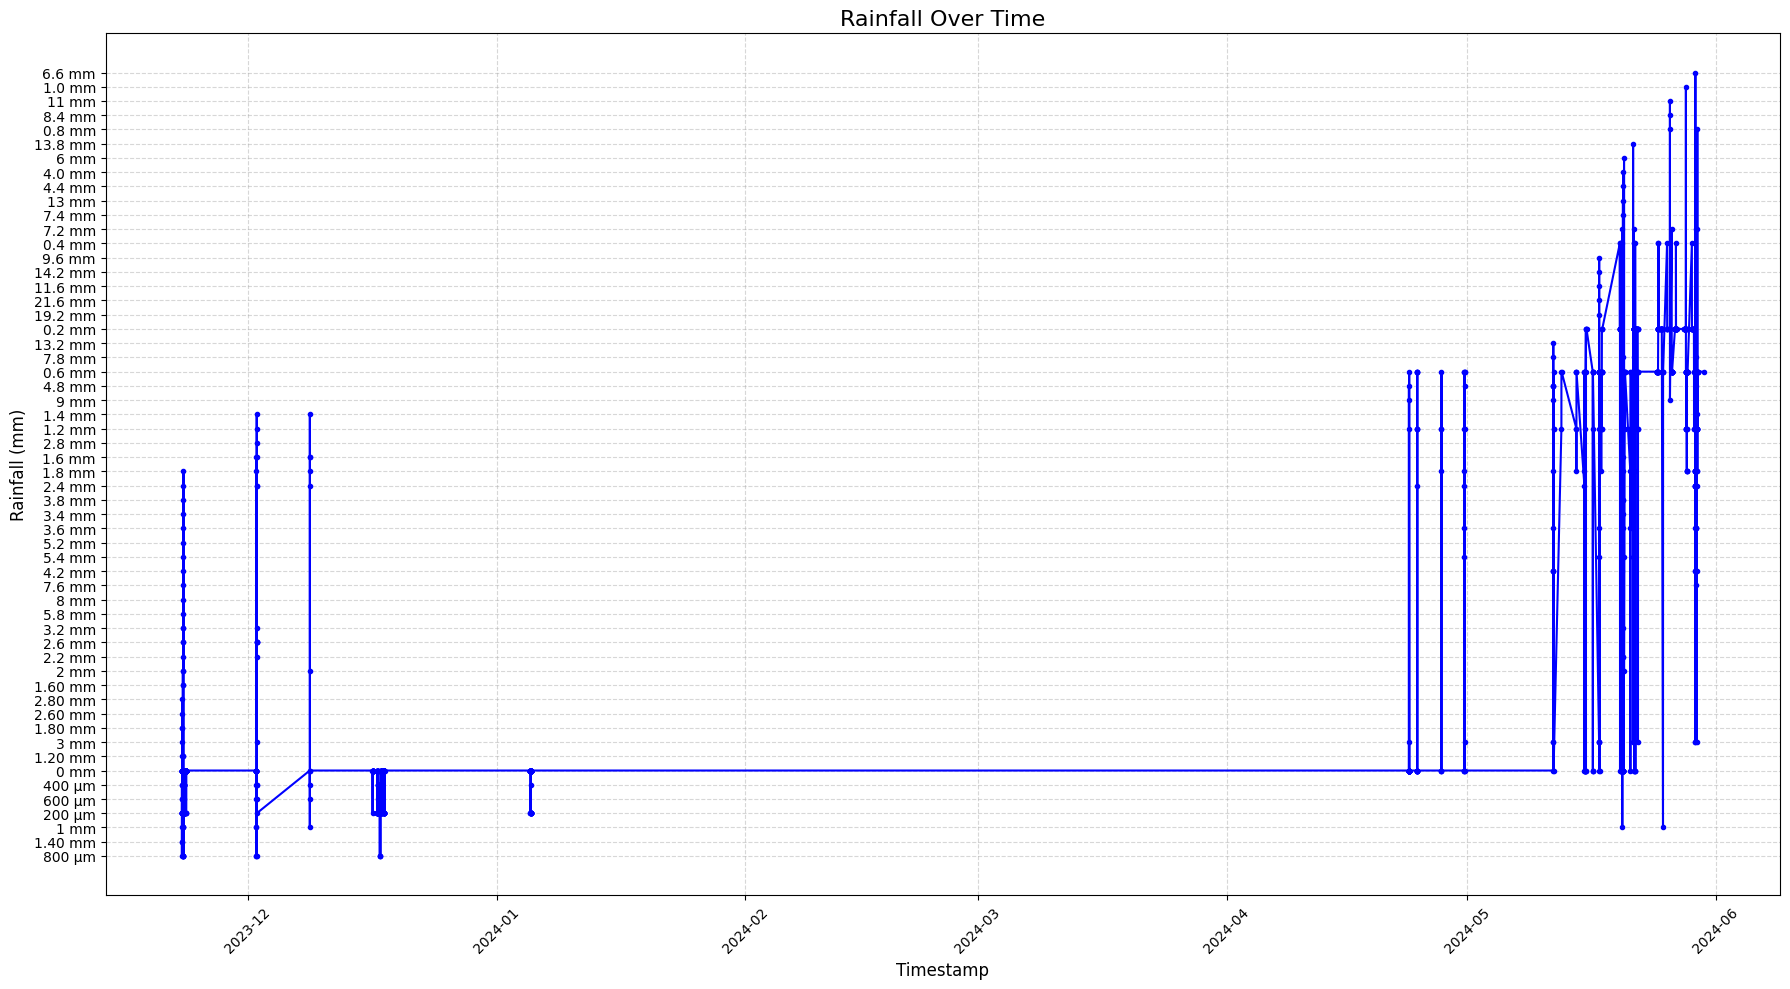

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and clean CSV
df = pd.read_csv('/kaggle/input/rain-data-master-8k/rain_data_mechanical_master.csv')
df.columns = df.columns.str.strip()
df.rename(columns={
    'Time': 'timestamp',
    'device_frmpayload_data_rainfall': 'rainfall'
}, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by timestamp if needed
df.sort_values(by='timestamp', inplace=True)

# Plot
plt.figure(figsize=(18, 10))  # Larger figure for clarity
plt.plot(df['timestamp'], df['rainfall'], color='blue', linewidth=1.5, marker='o', markersize=3)

plt.title("Rainfall Over Time", fontsize=16)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Rainfall (mm)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [92]:
# Load and clean dataset
df = pd.read_csv('/kaggle/input/rain-data-master-8k/rain_data_mechanical_master.csv')
df.columns = df.columns.str.strip()

# Rename columns
df.rename(columns={
    'Time': 'timestamp',
    'device_frmpayload_data_rainfall': 'rainfall'
}, inplace=True)

# Clean rainfall values: remove 'mm', whitespace, and convert to float
df['rainfall'] = df['rainfall'].astype(str).str.replace('mm', '', regex=False).str.strip()
df['rainfall'] = pd.to_numeric(df['rainfall'], errors='coerce')

# Drop NaNs after conversion
df = df.dropna(subset=['rainfall'])

# Check number of valid rows and non-zero values
print("Rainfall type:", df['rainfall'].dtype)
print("Total rows:", len(df))
print("Non-zero rainfall rows:", (df['rainfall'] > 0).sum())

Rainfall type: float64
Total rows: 1031
Non-zero rainfall rows: 676


In [93]:
# Convert time column
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Get max and min rows
max_day = df.loc[df['rainfall'].idxmax()]
min_day = df.loc[df['rainfall'].idxmin()]

print("🌧️ Max rainfall:", max_day['rainfall'], "mm on", max_day['timestamp'].date())
print("🌤️ Min rainfall:", min_day['rainfall'], "mm on", min_day['timestamp'].date())

🌧️ Max rainfall: 21.6 mm on 2024-05-17
🌤️ Min rainfall: 0.0 mm on 2023-11-22


In [94]:
import pandas as pd
import os

# Load CSV
rain_csv = pd.read_csv('/kaggle/input/rain-data-master-8k/rain_data_mechanical_master.csv')
rain_csv.columns = rain_csv.columns.str.strip()  # Remove spaces if any

# Rename for easier access
rain_csv.rename(columns={
    'Time': 'timestamp',
    'device_frmpayload_data_rainfall': 'rainfall'
}, inplace=True)

# Convert 'timestamp' to datetime, then to UNIX time
rain_csv['timestamp'] = pd.to_datetime(rain_csv['timestamp'])
rain_csv['unix_time'] = rain_csv['timestamp'].astype('int64') // 10**9

# Load audio filenames
audio_dir = '/kaggle/input/rain-data-master-8k/rainfall_sound_8k'
audio_files = sorted(os.listdir(audio_dir))
audio_timestamps = [int(f.replace('.wav', '')) for f in audio_files]
audio_timestamps_set = set(audio_timestamps)

# Function to get audio clips for a given UNIX timestamp
def get_audio_clips_for_timestamp(unix_time):
    start_time = unix_time - 180  # 3 minutes window
    relevant_clips = []
    for ts in range(start_time, unix_time + 1):
        if ts in audio_timestamps_set:
            relevant_clips.append(f"{ts}.wav")
    return relevant_clips

# Example: test on first row
sample_unix = rain_csv.iloc[0]['unix_time']
clips = get_audio_clips_for_timestamp(sample_unix)

print("Timestamp:", rain_csv.iloc[0]['timestamp'])
print("Clips in the previous 3 minutes:", clips)

Timestamp: 2023-11-22 18:27:26
Clips in the previous 3 minutes: []


In [95]:
# To load the saved audio array later:
loaded_array = np.load(save_path)
print("Loaded array shape:", loaded_array.shape)

Loaded array shape: (0,)


In [97]:
def combine_audio(clips):
    combined = []
    for clip in clips:
        data, _ = librosa.load(os.path.join(audio_dir, clip), sr=None)
        combined.extend(data)
    return np.array(combined)

In [98]:
combined_audio = combine_audio(get_audio_clips_for_timestamp(rain_csv['unix_time'][0]))
np.save("combined_audio.npy", combined_audio)

In [102]:
def extract_features(signal):
    if signal.size == 0:
        return {
            'mean': np.nan,
            'std': np.nan,
            'max': np.nan,
            'min': np.nan,
            'energy': np.nan
        }
    
    return {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'energy': np.sum(signal**2)
    }

In [104]:
for i in range(10):
    ts = rain_csv['unix_time'][i]  # ✅ Use UNIX time instead of timestamp
    rainfall = rain_csv['rainfall'][i]
    
    clips = get_audio_clips_for_timestamp(ts)
    
    if len(clips) == 0:
        print(f"⚠️ No audio clips found for timestamp {ts}")
        continue
    
    print(f"\n⏱️ Timestamp {ts} | Rainfall: {rainfall}")
    print("🔊 Matching Clips:", clips)
    
    combined = combine_audio_for_timestamp(ts)
    print("🎧 Combined Audio Length:", len(combined))

    if combined.size > 0:
        features = extract_features(combined)
        print("📊 Features:", features)
    else:
        print("⚠️ No audio to extract features from.")

⚠️ No audio clips found for timestamp 1700677646
⚠️ No audio clips found for timestamp 1700677826
⚠️ No audio clips found for timestamp 1700678006
⚠️ No audio clips found for timestamp 1700678186
⚠️ No audio clips found for timestamp 1700678366
⚠️ No audio clips found for timestamp 1700678546
⚠️ No audio clips found for timestamp 1700678726
⚠️ No audio clips found for timestamp 1700679086
⚠️ No audio clips found for timestamp 1700679266
⚠️ No audio clips found for timestamp 1700679446
